<a href="https://colab.research.google.com/github/stevengregori92/CNN-Intro/blob/main/LandscapeClassification_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "jcopdl<2.0"
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17913 sha256=7876e7aca003e5715163cc400079d804117e6d48864d2481fec9ef4fe48d6dd5
  Stored in directory: /root/.cache/pip/wheels/41/95/30/86345d2446be19c7d97dee789a2597bee81cfbb7b24a847f7c
Successfully built jcopdl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
!gdown https://drive.google.com/uc?id=1sPjiRVfH2UrxeiePQ7C7a7ZvLQ754X20

Downloading...
From: https://drive.google.com/uc?id=1sPjiRVfH2UrxeiePQ7C7a7ZvLQ754X20
To: /content/landscape.zip
100% 520M/520M [00:08<00:00, 59.7MB/s]


In [5]:
!unzip /content/landscape.zip

Streaming output truncated to the last 5000 lines.
  inflating: Landscape Classification/Landscape Classification/Training Data/Glacier/Glacier-Train (1449).jpeg  
  inflating: Landscape Classification/Landscape Classification/Training Data/Glacier/Glacier-Train (145).jpeg  
  inflating: Landscape Classification/Landscape Classification/Training Data/Glacier/Glacier-Train (1450).jpeg  
  inflating: Landscape Classification/Landscape Classification/Training Data/Glacier/Glacier-Train (1451).jpeg  
  inflating: Landscape Classification/Landscape Classification/Training Data/Glacier/Glacier-Train (1452).jpeg  
  inflating: Landscape Classification/Landscape Classification/Training Data/Glacier/Glacier-Train (1453).jpeg  
  inflating: Landscape Classification/Landscape Classification/Training Data/Glacier/Glacier-Train (1454).jpeg  
  inflating: Landscape Classification/Landscape Classification/Training Data/Glacier/Glacier-Train (1455).jpeg  
  inflating: Landscape Classification/Landscap

#Dataset & Dataloader

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [8]:
bs=128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('Landscape Classification/Landscape Classification/Training Data', transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle = True, num_workers=2)

test_set = datasets. ImageFolder('Landscape Classification/Landscape Classification/Testing Data', transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle = True)

In [9]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [10]:
label2cat = train_set.classes
label2cat

['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']

#Arsitektur dan Config

In [11]:
from jcopdl.layers import conv_block, linear_block

In [12]:
nn.Conv2d(3,8,3,1,1)

Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [13]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv=nn.Sequential(
        conv_block(3, 8),
        conv_block(8, 16),
        conv_block(16, 32),
        conv_block(32, 64),
        nn.Flatten()
    )
    self.fc = nn.Sequential(
        linear_block(1024, 256, dropout=0.1),
        linear_block(256, 5, activation='lsoftmax')
    )

  def forward(self, x):
    x = self.conv(x)
    x = self.fc(x)
    return x

In [14]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size
})

#Training Prepareation

In [15]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='model')

#Training Loop include Acc

In [16]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device) # corrected line
        output = model(feature)
        loss = criterion(output, target)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
        
    cost = cost/len(dataset)
    acc = correct/len(dataset)
    return cost, acc

Train:   0%|          | 0/79 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 1.2705 | Test_cost  = 1.0372 | Train_score = 0.4663 | Test_score = 0.5860 |


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.9916 | Test_cost  = 0.9440 | Train_score = 0.6088 | Test_score = 0.6320 |


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.9286 | Test_cost  = 0.8691 | Train_score = 0.6400 | Test_score = 0.6520 |


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>if w.is_alive():

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
can only test a child process    
if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.8613 | Test_cost  = 0.8666 | Train_score = 0.6646 | Test_score = 0.6440 |
==> EarlyStop patience =  1 | Best test_score: 0.6520


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.8424 | Test_cost  = 0.8006 | Train_score = 0.6703 | Test_score = 0.6980 |


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorif w.is_alive():: 
can only test a child process
  File "/usr/lib/

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.8404 | Test_cost  = 0.8271 | Train_score = 0.6717 | Test_score = 0.6660 |
==> EarlyStop patience =  1 | Best test_score: 0.6980


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Exception ignored in: <function _Multi

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.8063 | Test_cost  = 0.7868 | Train_score = 0.6885 | Test_score = 0.6900 |
==> EarlyStop patience =  2 | Best test_score: 0.6980


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.7884 | Test_cost  = 0.8214 | Train_score = 0.6976 | Test_score = 0.6800 |
==> EarlyStop patience =  3 | Best test_score: 0.6980


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/usr/local/lib/python3.10/dist-packages/tor

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.7871 | Test_cost  = 0.8351 | Train_score = 0.7009 | Test_score = 0.6660 |
==> EarlyStop patience =  4 | Best test_score: 0.6980


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.7733 | Test_cost  = 0.7318 | Train_score = 0.7043 | Test_score = 0.7200 |


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.7454 | Test_cost  = 0.7556 | Train_score = 0.7199 | Test_score = 0.7100 |
==> EarlyStop patience =  1 | Best test_score: 0.7200


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.7463 | Test_cost  = 0.6865 | Train_score = 0.7175 | Test_score = 0.7220 |


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.7307 | Test_cost  = 0.7289 | Train_score = 0.7225 | Test_score = 0.7220 |
==> EarlyStop patience =  1 | Best test_score: 0.7220


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.7237 | Test_cost  = 0.7194 | Train_score = 0.7272 | Test_score = 0.7200 |
==> EarlyStop patience =  2 | Best test_score: 0.7220


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.7147 | Test_cost  = 0.6723 | Train_score = 0.7283 | Test_score = 0.7420 |


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/d

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.6997 | Test_cost  = 0.6639 | Train_score = 0.7352 | Test_score = 0.7320 |
==> EarlyStop patience =  1 | Best test_score: 0.7420


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.6999 | Test_cost  = 0.7583 | Train_score = 0.7354 | Test_score = 0.7040 |
==> EarlyStop patience =  2 | Best test_score: 0.7420


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
Exception ignored

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.7105 | Test_cost  = 0.6982 | Train_score = 0.7361 | Test_score = 0.7080 |
==> EarlyStop patience =  3 | Best test_score: 0.7420


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.6735 | Test_cost  = 0.6715 | Train_score = 0.7473 | Test_score = 0.7340 |
==> EarlyStop patience =  4 | Best test_score: 0.7420


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff552a5de10>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
if w.is_alive():    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
self._shutdown_workers()AssertionError
:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
can only test a child process    
if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.6807 | Test_cost  = 0.6619 | Train_score = 0.7412 | Test_score = 0.7400 |


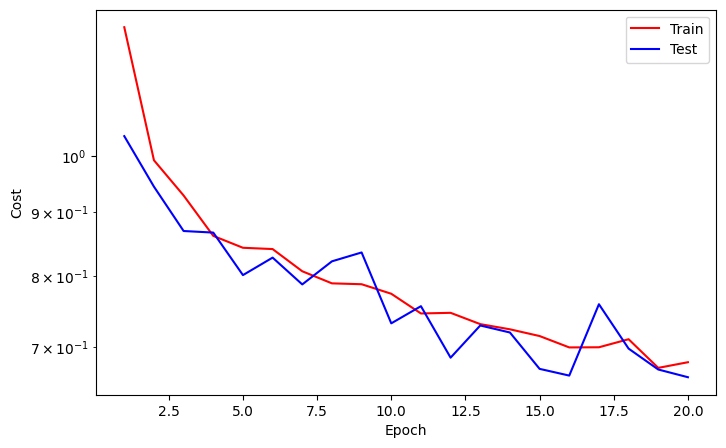

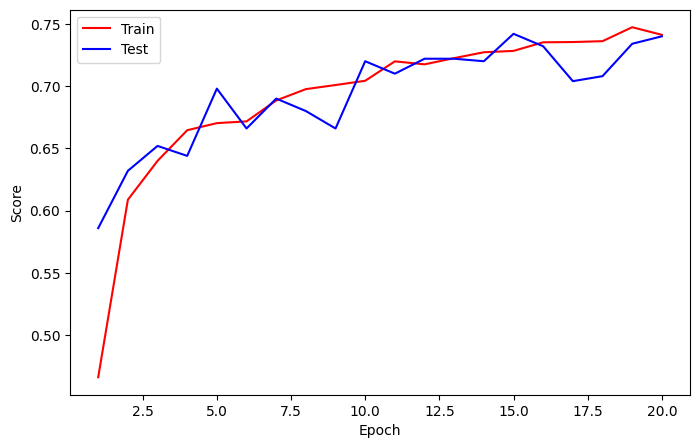

==> EarlyStop patience =  5 | Best test_score: 0.7420
==> Execute Early Stopping at epoch: 20 | Best test_score: 0.7420
==> Best model is saved at model


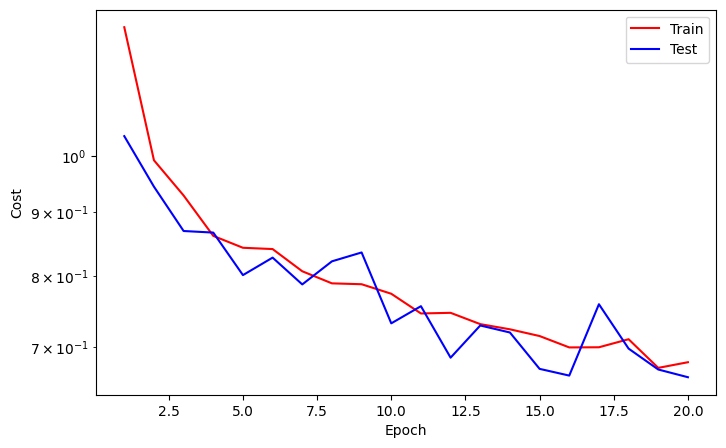

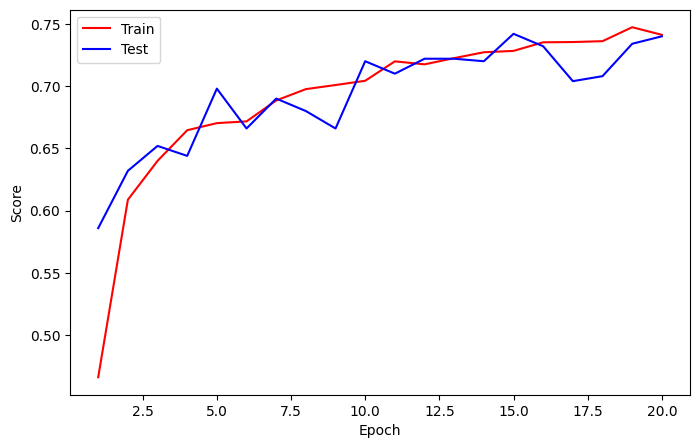

In [17]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
      test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  #Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

#Predict

In [18]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [19]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = output.argmax(1)
preds

tensor([3, 3, 3, 2, 1, 2, 0, 1, 3, 4, 4, 2, 2, 3, 0, 0, 1, 0, 0, 1, 1, 3, 2, 2,
        3, 3, 4, 2, 0, 0, 2, 1, 4, 2, 0, 1, 3, 3, 1, 3, 1, 2, 1, 0, 1, 2, 0, 4,
        4, 2, 2, 3, 0, 1, 4, 0, 2, 2, 3, 4, 2, 3, 1, 2, 3, 4, 3, 4, 1, 4, 4, 2,
        1, 4, 4, 0, 3, 0, 3, 1, 3, 1, 2, 1, 0, 3, 3, 3, 3, 2, 1, 3, 2, 1, 3, 3,
        1, 2, 0, 2, 0, 1, 0, 3, 1, 3, 0, 2, 1, 4, 4, 0, 1, 4, 2, 0, 2, 3, 0, 3,
        1, 1, 2, 2, 4, 1, 4, 1], device='cuda:0')

#Visualize

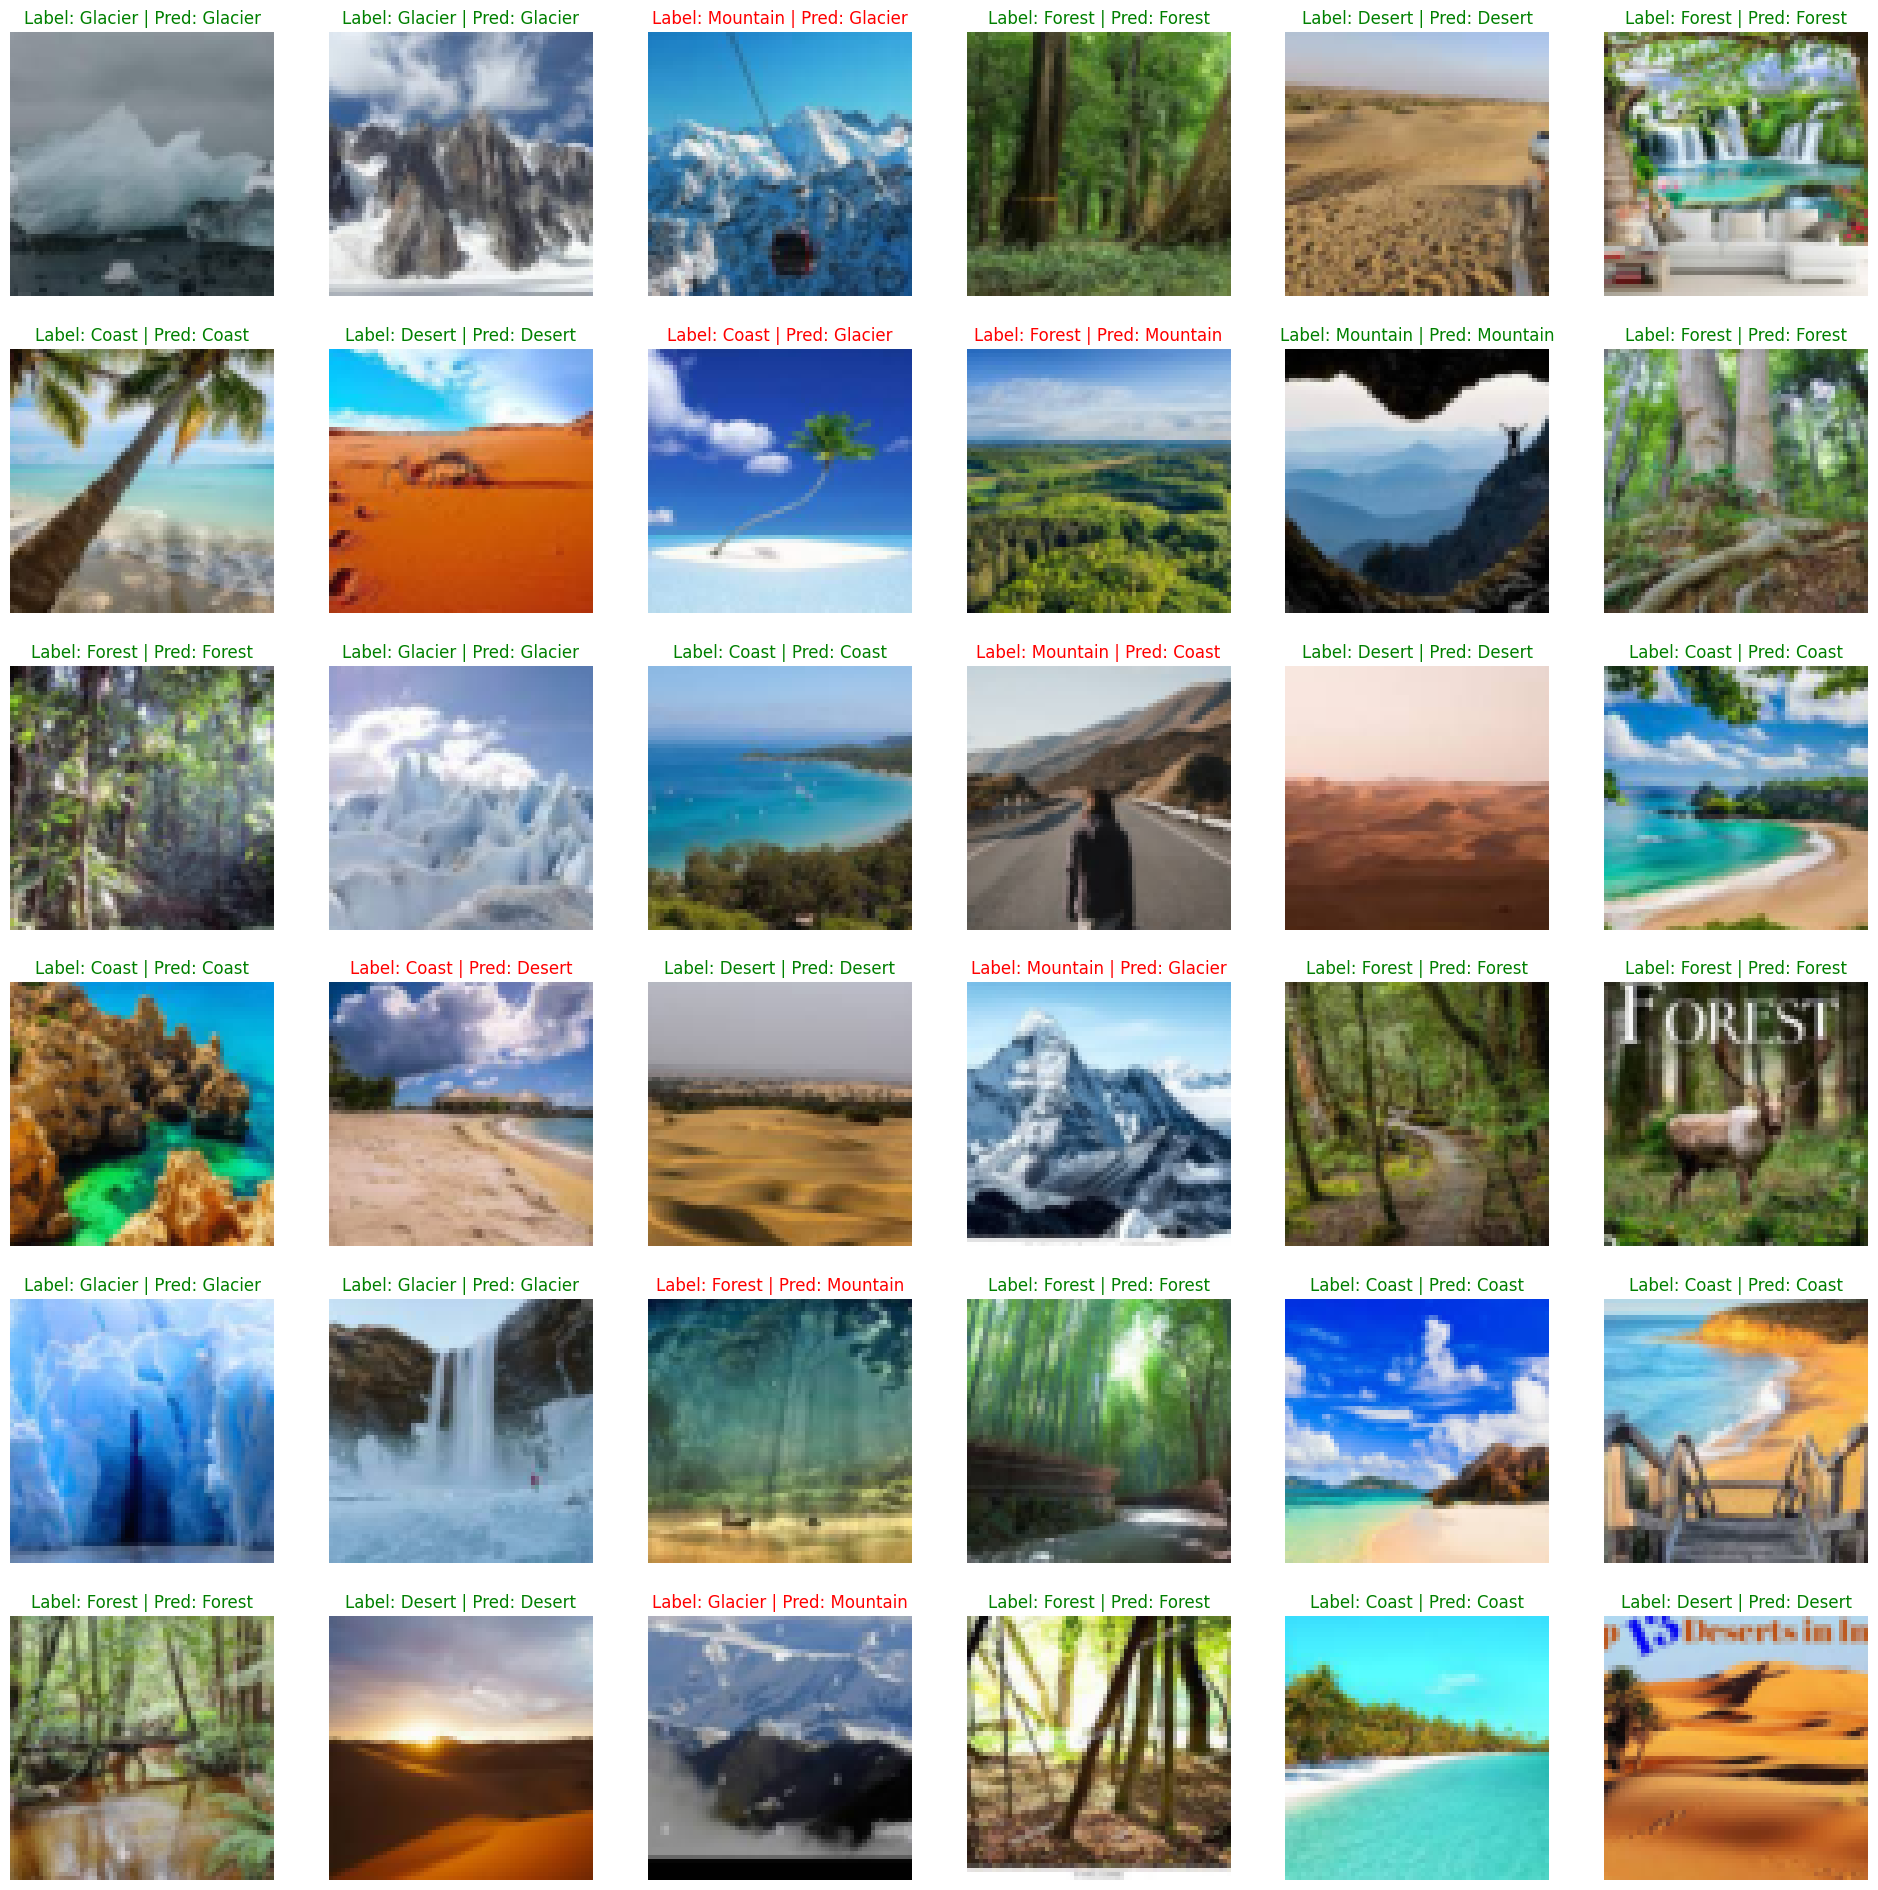

In [20]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {'color': 'r'} if label.item() != pred.item() else {'color': 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f'Label: {label} | Pred: {pred}', fontdict=font)
    ax.axis('off')

plt.show()
